# Practice Session PS06: Recommendation engines (Content-based)

For this assignment we will build and apply a content-based recommender for movies. 

# 0. Preliminaries

## 0.1. Datasets

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the MovieLens DataSet. The Grouplens research has collected data since 1997.  

Depending on the size of the dataset, we can find different sizes as the following table shows:

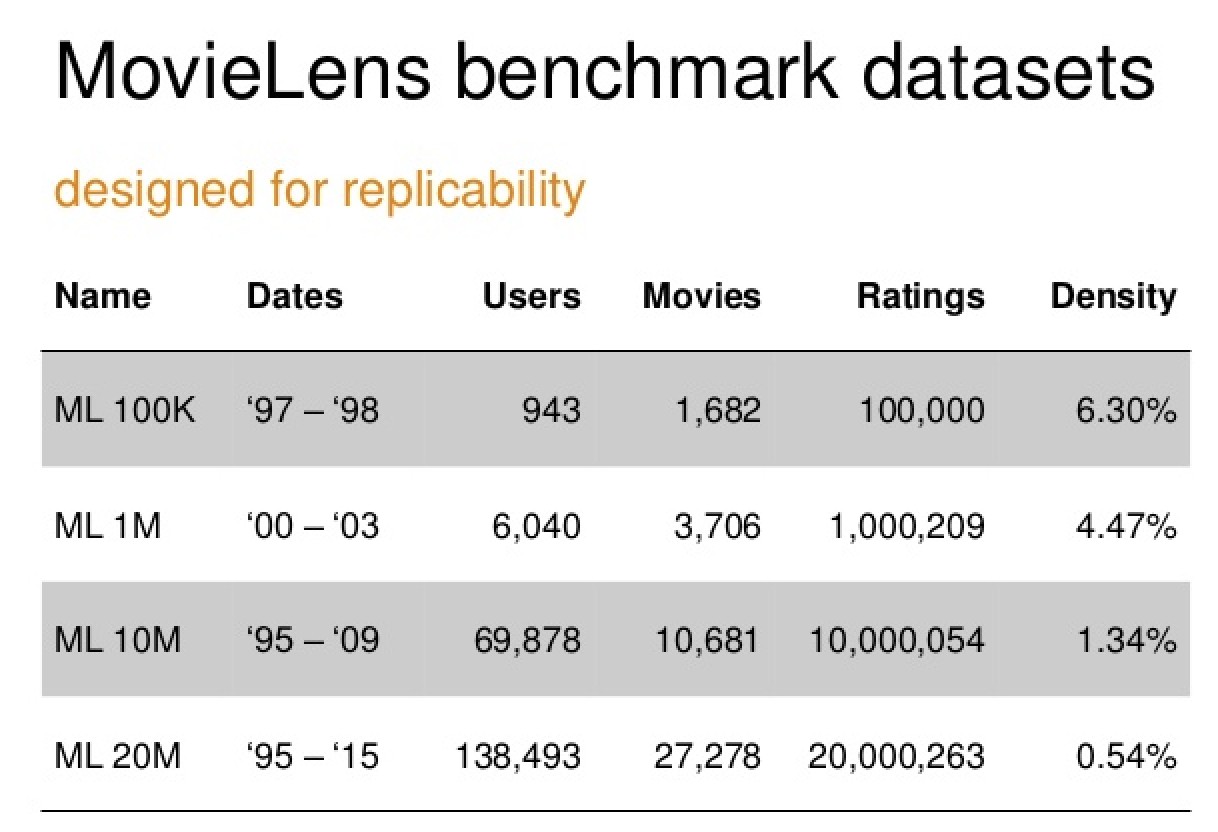

In this assignment we are going to use the 1M version, that was released on February 2003. The main characteristics are:
* All users selected had rated at least 20 movies
* Each user is represented by an id

The data within the `movielens-1M.zip` archive is contained in three files: `movies.dat`, `ratings.dat`, and `users.dat`. 

***RATINGS FILE DESCRIPTION***


All ratings are contained in the file `ratings.dat` and are in the following format:

`UserID::MovieID::Rating::Timestamp`

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

**USERS FILE DESCRIPTION**


User information is in the file `users.dat` and is in the following format:

`UserID::Gender::Age::Occupation::Zip-code`

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this dataset.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

***MOVIES FILE DESCRIPTION***


Movie information is in the file `movies.dat` and is in the following format:

`MovieID::Title::Genres`

- Titles are identical to titles provided by the IMDB (including year of release)
- Genres are pipe-separated ("|") and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

## 0.2. Required imports

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd   
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## 0.3. Load the data

Load the 3 dataset within three dataframes named `ratings`, `users`, and `movies` considering the data structure explained above. Look at the first 10 records on each dataframe.

In [2]:
# Read the Ratings File
ratings = pd.read_csv("ratings.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])


In [3]:
ratings.head(10)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [4]:
# Read the Users File
users = pd.read_csv("users.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])

In [5]:
users.head(10)

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [6]:
# Read the Movies File
movies = pd.read_csv("movies.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])

In [7]:
movies.head(10)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


# 1. Exploratory Data Analysis

## 1.0. Main data characteristics

[**REPORT**] Create a table per `movies`, `users`and `ratings`dataframes with their main characteristics (i.e. number of rows, number of columns, and type of each column).

## 1.1. "Ratings" variable
To have a clear understanding of the data, it is key to know the distribution of the main variables.
With the **.describe** function of Pandas, we can get a summary of the main statistics of a numeric variable:

In [11]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Besides, it is key to know their distribution.

[**REPORT**] Generate a plot with the ditribution of the ratings and verify ratings are quite high: the mean is over 3 (from 5).

Now, let's join all 3 files into one dataframe and display how this merge looks like.

In [13]:
dataset = pd.merge(pd.merge(movies, ratings),users)
dataset.head(20)

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067
5,531,"Secret Garden, The (1993)",Children's|Drama,1,4,978302149,F,1,10,48067
6,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,978824268,F,1,10,48067
7,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1,4,978302268,F,1,10,48067
8,595,Beauty and the Beast (1991),Animation|Children's|Musical,1,5,978824268,F,1,10,48067
9,608,Fargo (1996),Crime|Drama|Thriller,1,4,978301398,F,1,10,48067


To see how users evaluated an specific movie, let's filter the merged dataframe for any particular movie, e.g. "Toy Story (1995)"

In [14]:
dataset[dataset["title"]=="Toy Story (1995)"].head(20)

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
53,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50,9,55117
124,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25,12,11413
263,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25,17,61614
369,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35,1,95370
770,1,Toy Story (1995),Animation|Children's|Comedy,18,4,978154768,F,18,3,95825
1075,1,Toy Story (1995),Animation|Children's|Comedy,19,5,978555994,M,1,10,48073
1330,1,Toy Story (1995),Animation|Children's|Comedy,21,3,978139347,M,18,16,99353
1352,1,Toy Story (1995),Animation|Children's|Comedy,23,4,978463614,M,35,0,90049
1656,1,Toy Story (1995),Animation|Children's|Comedy,26,3,978130703,M,25,7,23112


## 1.2. "Genres" variable
Tipically, genre is one of the most important descriptor for a movie recommendation engine: a basic assumption is that films in the same genre should have similar contents. 
Because of this, we have to know how this variable is, i.e. the values or categories, number or ratio of each categories, etc.

[**CODE**] Create a function to count the number of appearances each genre in the **movies** dataframe

In [16]:
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    #ADD YOUR CODE
    
    return keyword_occurences

If we apply the new `count_word`, the output should be similar to:

In [17]:
keyword_occurences = count_word(movies, 'genres', genre_labels)
keyword_occurences[0:10]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211]]

[**REPORT**] Include a table with the number of movies per genre in your dataset, considering that a movie could belong to different ones.

Data Visualization is a technique that supports decision-making process in data mining. A wordcloud is very useful plot for text. We will use a [WordCloud Library](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) by Andreas Mueller.

[**CODE**] Create a wordcloud plot with the their genres and its occurences following the next steps: 

In [1]:
#First, create the dictionary used to produce the genre wordcloud
# - create dictionary "genres"
#ADD YOUR CODE HERE

#Second, create the wordcloud
# - create object "genre_wordcloud = WordCloud(...)"
# - generate word cloud from frequencies in "genres"
#ADD YOUR CODE HERE

Now, we are ready the plot of the wordcloud and it should look like: 

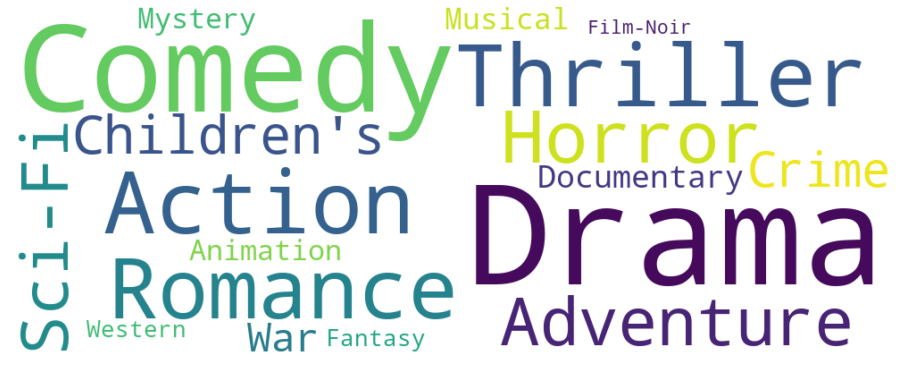

In [19]:
# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

[**REPORT**] Include this wordcloud in your report.

# 2. Recommendation implementations

## 2.1. Content-based recommendation

A content-based recommender works with data that describes the movie (or content). In our case, we will mainly use the genres that describes each movie. Our assumption is that films in the same genre should have similar contents and therefore are more likely to be recommended.

However, we could extend the content-based taking into account the user reviews, director, actors and any other characteritics that explicitly describes the movie.


### 2.1.1 Data pre-processing: TF-IDF

**Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are techniques used in information retrieval to determine the **importance** of a word. In our use case, content-based recommendation, TF-IDF will be used to measure the importance of each genre in each movie. 
Meanwhile, TF is simply the frequency of a word in a document, IDF is the inverse of the document frequency among the whole corpus of documents. Usually, TF and IDF are combined to measure the real importance of a word across different documents. TF-IDF weighting negates the effect of high frequency words but with low importance from a semantic point of view.
The next image below describes the way to calculate the TF-IDF score:

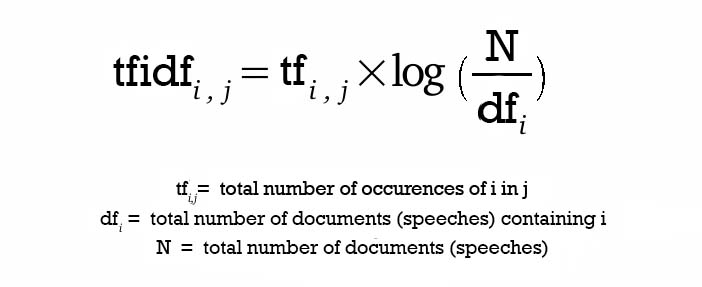

As a movie can belong to several genres, we should break up the genre string into a string array.

In [20]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

[**CODE**] Apply [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) function from Scikit-Learn.

Create variable `tfidf_matrix`.

*Note:* that this is a sparse matrix so when displaying it, Python might print it in sparse format. A matrix such as:

```
[[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]
```

Might be printed as:

```
  (0, 0)	1
  (0, 3)	1
  (1, 2)	2
  (1, 5)	1
  (2, 3)	2
```

[**REPORT**] Include in your report the dimension of the TF-IDF matrix resulting from the text processing, indicating clearly how many documents and how many words are in this matrix.

### 2.1.2. Content-based model implementation

As previously explained, the calculated TF-IDF from **genre** will be the variable to describe the content; i.e. in our case, the movie. 
The **similarity** will be measured considering the angle between the vectors generated after the TF-IDF process. Each movie becomes a vector of attributes in an **n-dimensional space** where the angles between the vectors **determines the similarity**. 
The method of calculating this relative measure is taking the cosine of the angle between two vectors. The vectors are length normalized and then the cosine calculation is simply the sum-product of vectors. 

For a more generic perspective, the next image is an example of several sentences represented by its vector space where Sentence 2 is more likely to be using Term 2 than using Term 1.
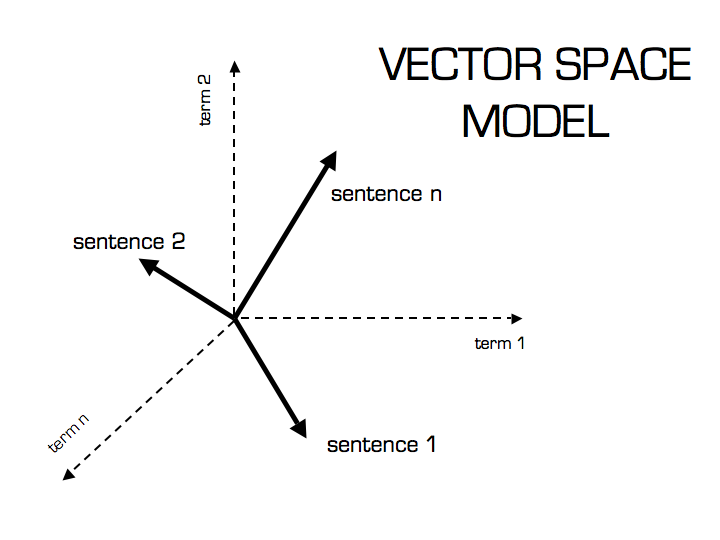


[**CODE**] Calculate the cosine similarity from the TF-IDF vector space previously calculated.

Create variable `cosine_sim` with all pairwise similarities in `tfidf_matrix`

[**REPORT**] Build a table with the cosine similarity between  the first 5 movies

#### Note: sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function is faster than the cosine_similarities function.


To build the final content-based recommendation, firstly, we should build an array to store the recommended movies. 

In [25]:
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

[**CODE**] Write a function that returns the **num_movies** most similar movies based on the cosine similarity score in a new dataframe.

In [3]:
# Solution
def genre_content_based_recommendations(title, num_movies=10):
    recomendation_df = pd.DataFrame(columns=["movie_id,", "Title", "Similarity"])
    ## ADD YOUR CODE
    
    return recomendation_df

Now, let's explore how our recommendation engine works.

[**REPORT**] Get the top 10 recommended movies for **"Toy Story (1995)"**.

[**REPORT**] Briefly explain pros and cons of content-based recommendation engines in terms of cost computation, cold-start and any other aspect you consider.

# Deliver (individually)

Deliver:

* A zip file containing your notebook (.ipynb file) with all the "[**CODE**]" parts implemented.
* A 4-pages PDF report including all parts of this notebook marked with "[**REPORT**]"

The report should end with the following statement: **I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.**